In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import morphology

#anaconda torch is the environment


# from skimage.transform import rotate
# from skimage.feature import local_binary_pattern
# from skimage import data
from skimage.color import label2rgb

Packages for this project

pip install numpy
pip install matplotlib
pip install opencv-python
pip install scikit-image
pip install pyfftw

#to install phasepack 
#go to the directory phasepack-1.5
#and type: 
#python setup.py install

In [4]:
from phasepack import phasesym

In [54]:
from skimage.color import label2rgb

def seis_cube(file,nx,ni,ns):
    size_data=[nx*1,ni*1,ns*1]
    seis=np.fromfile(file,dtype=np.float32)
    seis=np.reshape(seis,size_data)
    return seis


def imgs_show(im1,im2,title1='image 1',title2='image 2'):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(im1,cmap='gray')
    ax1.set_title(title1)
    ax2.imshow(im2,cmap='gray')
    ax2.set_title(title2)

def im_rescale(img,mi=0,ma=1):
    imi=img.min()
    ima=img.max()
    d=ima-imi
    imgr=mi+(img-imi)*ma/d
    return imgr
    
def img_show(im,cmp='gray'):
    plt.imshow(im,cmap=cmp)

def seis_show(im):
    plt.imshow(im,cmap=plt.cm.seismic)


def rem_small_objs1(image,disk=1):
    footprint=morphology.disk(disk)
    res= morphology.white_tophat(image, footprint)
    return image-res

def rem_small_objs2(image,min_size=64,con=1):
    imager=im_rescale(image)*255 
    imager=imager.astype(int)
    res= morphology.remove_small_objects(imager,min_size,connectivity=con)
    return imager-res    


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

#float image  to grayscale
def im2gray(im):
    imr=im_rescale(im,0,255)
    imr=imr.astype(np.uint8)
    return imr




In [33]:
from scipy.ndimage import filters
def sobel_edge_detection(image):
    """
    Apply the Sobel edge detection algorithm to the input image.

    Parameters:
        image (numpy array): The input image, assumed to be grayscale.

    Returns:
        edges (numpy array): The output edge map, where each pixel is 0 or 1.
    """

    # Define the Sobel kernels
    Kx = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

    # Apply the Sobel kernels to the image
    Gx = filters.convolve(image, Kx )
    Gy = filters.convolve(image, Ky)

    # Compute the gradient magnitude and direction
    G = np.sqrt(Gx**2 + Gy**2)
    theta = np.arctan2(Gy, Gx)

    # Apply non-maximum suppression to thin the edges
    edges = np.zeros_like(image)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            if theta[i, j] < 0:
                theta[i, j] += np.pi
            elif theta[i, j] > np.pi:
                theta[i, j] -= np.pi
            dx = int(np.round(theta[i, j]/np.pi*2))
            dy = 1 - dx
            if G[i-dx, j-dy] >= G[i, j]:
                edges[i, j] = 0
            else:
                edges[i, j] = 255

    return edges.astype(np.uint8)

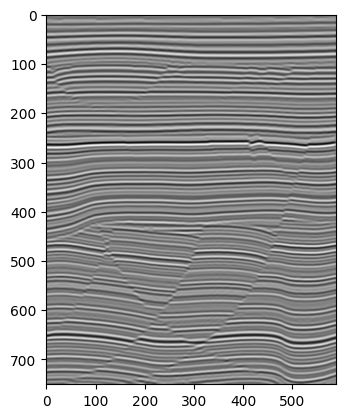

In [18]:
#loading some seismic image  extratted from seismic cube


seis_im50=np.load('seis_im50.npy')
mask_im50=np.load('mask_im50.npy')
#displaying in gray scale
img_show(seis_im50)
plt.show()


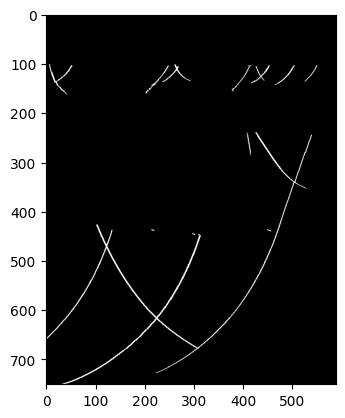

In [8]:
#and this an exmaple of anotation of faults in the image
img_show(mask_im50) 

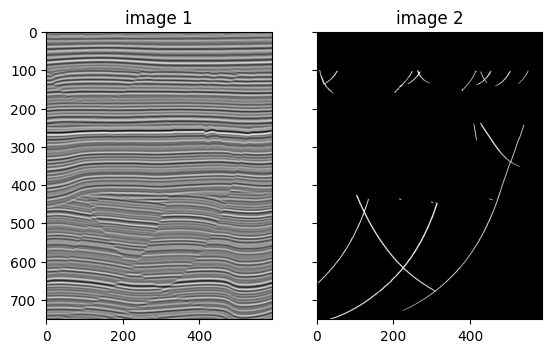

In [9]:
#showing both
imgs_show(seis_im50,mask_im50)

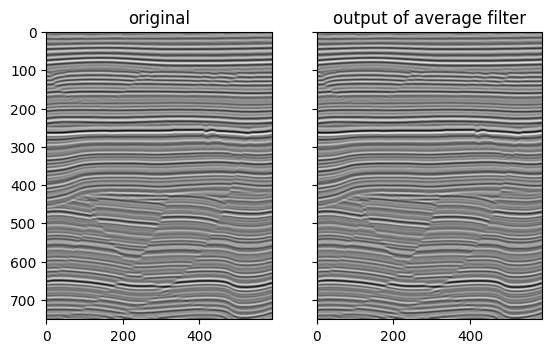

In [17]:
#here we introduce some examples of image convolution 
#using tipical filters (small array usually 3X3 5X5 size)
# average filter which smooth the image 
average_filter= np.ones((5,5),np.float32)/25
# horizontal sobel filter , which ennhaces edges in horizontal direction 
sobel_h=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
# vertical  sobel filter , which ennhaces edges in vertical direction 
sobel_v=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])

#For convolving the image, we use opencv libary (cv2)

out_seis_im50 = cv2.filter2D(seis_im50,-1,average_filter)
imgs_show(out_seis_im50,out_seis_im50,'original','output of average filter')  

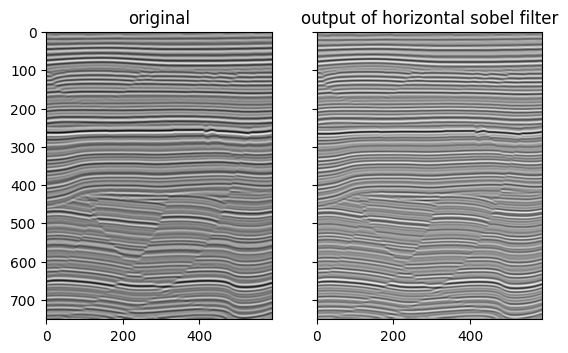

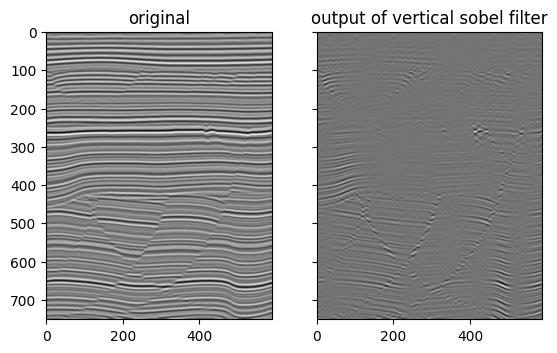

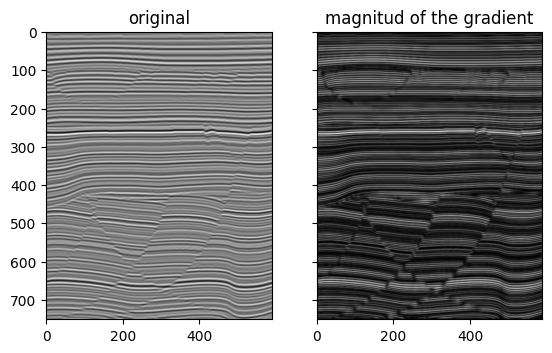

In [16]:
dsth = cv2.filter2D(out_seis_im50,-1,sobel_h)
imgs_show(out_seis_im50,dsth,'original','output of horizontal sobel filter')  

dstv = cv2.filter2D(out_seis_im50,-1,sobel_v)
imgs_show(out_seis_im50,dstv,'original','output of vertical sobel filter')  

#magnitud of the Sobel gradient
mag=np.sqrt(dstv*dstv+dsth*dsth)
imgs_show(seis_im50,mag,'original','magnitud of the gradient')  

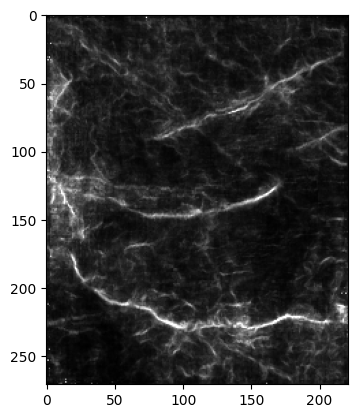

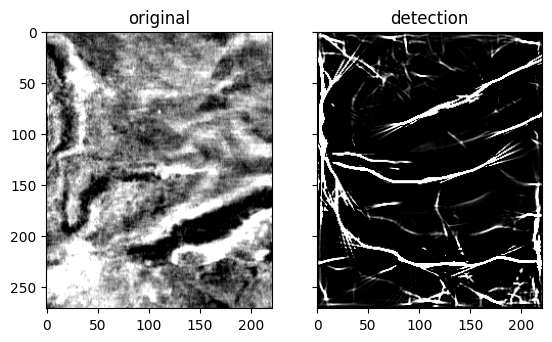

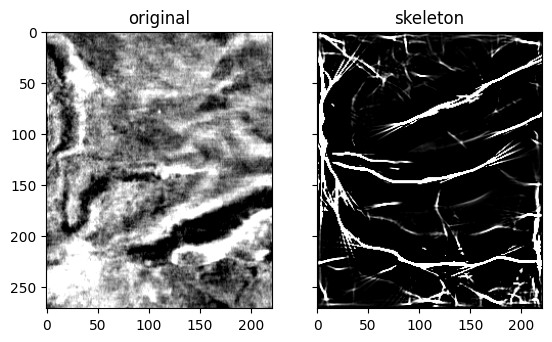

In [23]:
#some addtional seismic images

imgeo273=np.load('imgeo273.npy')
img_show(imgeo273)

#detect atribute from the image273
imgeo273_dtc=np.load('imgeo273_dtc.npy')
img_show(imgeo273_dtc)

#displaying both images
imgs_show(imgeo273,imgeo273_dtc, 'original','detection')

#skeleton  atribute from the imageo273
imgeo273_sk=np.load('imgeo273_sk.npy')
img_show(imgeo273_sk)

#displaying both images
imgs_show(imgeo273,imgeo273_sk, 'original','skeleton')

#now we apply another concept to the dtect attribute 
# def phasesym(img, nscale=5, norient=6, minWaveLength=3, mult=2.1,
#              sigmaOnf=0.55, k=2., polarity=0, noiseMethod=-1):
#     """
#     This function calculates the phase symmetry of points in an image. This is
#     a contrast invariant measure of symmetry. This function can be used as a
#     line and blob detector. The greyscale 'polarity' of the lines that you
#     want to find can be specified.

#     Arguments:
#     -----------
#     <Name>      <Default>   <Description>
#     img             N/A     The input image
#     nscale          5       Number of wavelet scales, try values 3-6
#     norient         6       Number of filter orientations.
#     minWaveLength   3       Wavelength of smallest scale filter.
#     mult            2.1     Scaling factor between successive filters.
#     sigmaOnf        0.55    Ratio of the standard deviation of the Gaussian
#                             describing the log Gabor filter's transfer function
#                             in the frequency domain to the filter center
#                             frequency.
#     k               2.0     No. of standard deviations of the noise energy
#                             beyond the mean at which we set the noise threshold
#                             point. You may want to vary this up to a value of
#                             10 or 20 for noisy images
#     polarity        0       Controls 'polarity' of symmetry features to find.
#                             1 only return 'bright' features
#                             -1 only return 'dark' features
#                             0 return both 'bright' and 'dark' features
#     noiseMethod     -1      Parameter specifies method used to determine
#                             noise statistics.
#                             -1 use median of smallest scale filter responses
#                             -2 use mode of smallest scale filter responses
#                             >=0 use this value as the fixed noise threshold

#     Returns:
#     ---------
#     phaseSym        Phase symmetry image (values between 0 and 1).
#     orientation     Orientation image. Orientation in which local symmetry
#                     energy is a maximum, in degrees (0-180), angles positive
#                     anti-clockwise. Note that the orientation info is quantized
#                     by the number of orientations
#     totalEnergy     Un-normalised raw symmetry energy which may be more to your
#                     liking.
#     T               Calculated noise threshold (can be useful for diagnosing
#                     noise characteristics of images). Once you know this you
#                     can then specify fixed thresholds and save some computation
#                     time.


#display the result:

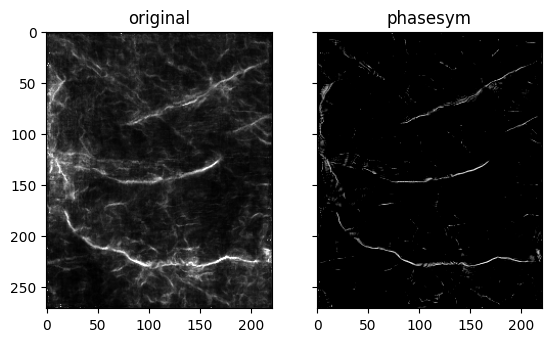

In [53]:
    
im_phasesym, orientation, totalEnergy, T=phasesym(imgeo273_dtc, nscale=5, norient=6,minWaveLength=3, \
         mult=2.1,sigmaOnf=0.55, k=2., polarity=0, noiseMethod=-1)
    
imgs_show(imgeo273_dtc,im_phasesym,'original','phasesym')


In [42]:
def autothresh(image):
#Automatic threshold method
# @param image: image to segment
#@return : threshold value
# """
    s = 0.5*( np.amin(image) + np.amax(image))
    done = False
    while ~done:
        B = image>=s;
        sNext = .5*( np.mean(image[B]) + np.mean(image[~B]))
        done = abs(s-sNext)<.5
        s = sNext
    return s

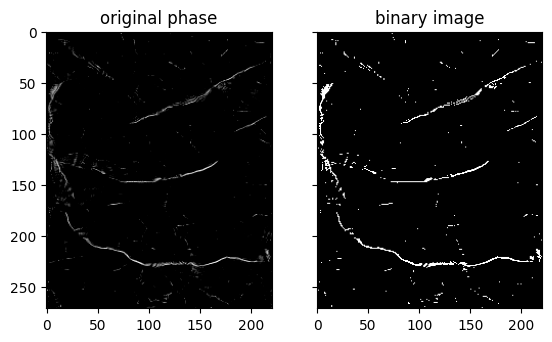

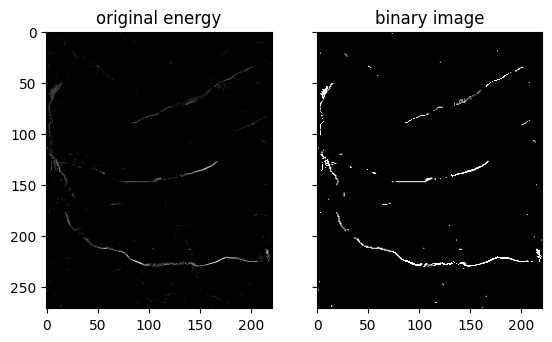

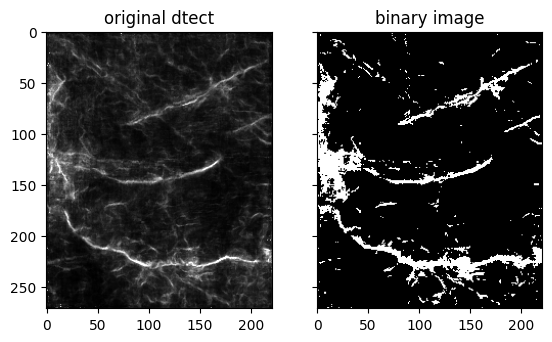

In [58]:
totalEnergyn=im2gray(totalEnergy)
imgeo273_dtcn=im2gray(imgeo273_dtc)
im_phasesymn=im2gray(im_phasesym)

s=autothresh(totalEnergyn)
s2=autothresh(imgeo273_dtcn)
s3=autothresh(im_phasesymn)

imgs_show(im_phasesymn,im_phasesymn>s3,'original phase','binary image')
plt.show()
imgs_show(totalEnergyn,totalEnergyn>s,'original energy','binary image')
plt.show()
imgs_show(imgeo273_dtcn,imgeo273_dtcn>s2,'original dtect','binary image') 
plt.show()

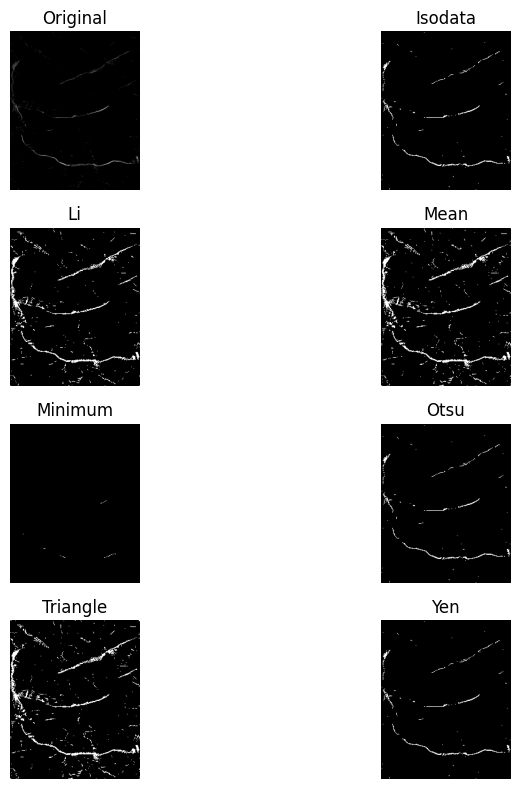

In [55]:
from skimage import data
from skimage.filters import try_all_threshold
img=totalEnergyn
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [51]:
from skimage.filters import threshold_otsu, threshold_local

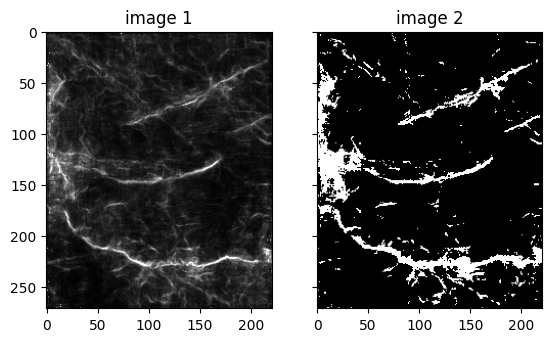

In [52]:
s_otsu = threshold_otsu( imgeo273_dtcn)
imgs_show(imgeo273_dtcn,imgeo273_dtcn>s_otsu)
plt.show()

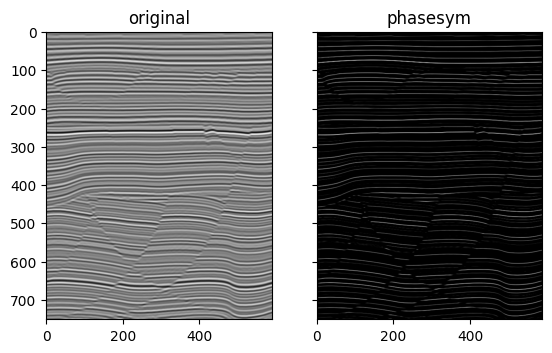

In [35]:
im_phasesym, orientation, totalEnergy, T=phasesym(seis_im50, nscale=5, norient=6,minWaveLength=2, \
         mult=2.1,sigmaOnf=0.55, k=4., polarity=1, noiseMethod=-1)
    
imgs_show(seis_im50,totalEnergy,'original','phasesym')

C:\Users\novalis\AppData\Local\Temp\ipykernel_5672\4252839271.py:22: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Gx = filters.convolve(image, Kx )
C:\Users\novalis\AppData\Local\Temp\ipykernel_5672\4252839271.py:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Gy = filters.convolve(image, Ky)


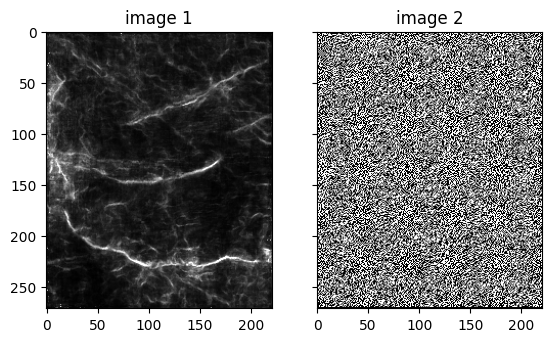

In [39]:
#sobel 
imgeo273_dtcn=im_rescale(imgeo273_dtc,mi=0,ma=1)
#seis_img50 to gray scale
imgeo273_dtcn=(imgeo273_dtcn*255).astype(np.uint8)

edges = sobel_edge_detection(imgeo273_dtcn)
imgs_show(imgeo273_dtc,edges)
plt.show()

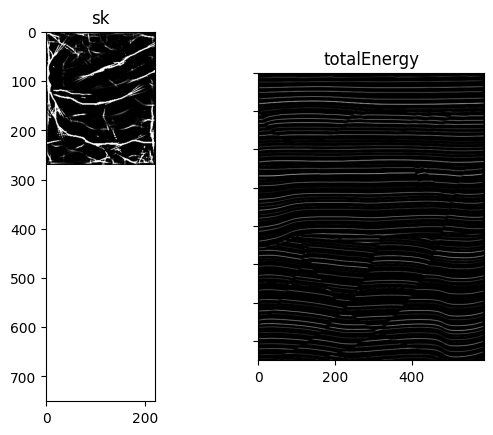

In [28]:
#compaering with attribute skeleton


imgs_show(imgeo273_sk,totalEnergy,'sk','totalEnergy')

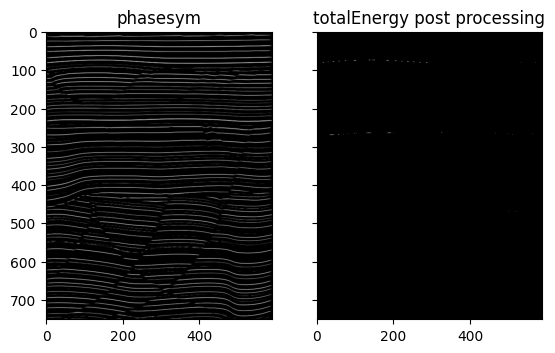

In [29]:
#post processing
#morphological operations

im_totalEnergy_mo=rem_small_objs2(totalEnergy,min_size=12,con=1)
imgs_show(im_phasesym,im_totalEnergy_mo,'phasesym','totalEnergy post processing')    

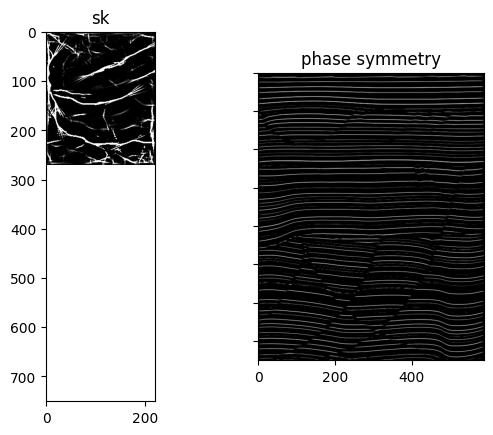

In [30]:
#compaering with attribute skeleton


imgs_show(imgeo273_sk,im_phasesym,'sk','phase symmetry')

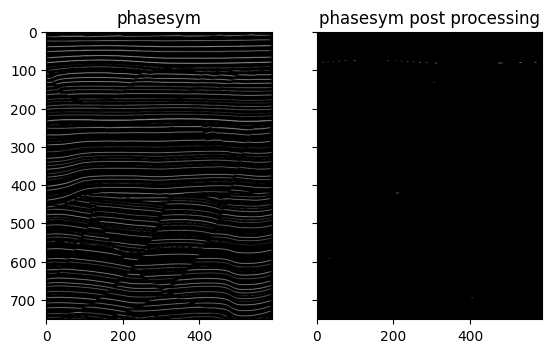

In [31]:
#post processing
#morphological operations

im_phasesym_mo=rem_small_objs2(im_phasesym,min_size=12,con=1)
imgs_show(im_phasesym,im_phasesym_mo,'phasesym','phasesym post processing')    
